In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import copy

!pip install torchmetrics
import torchmetrics

!pip install einops
import einops



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!gdown https://drive.google.com/uc?id=1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2
!mv Dataset_Student_annot_copy.zip Dataset_Student_annot.zip
#https://drive.google.com/file/d/1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2/view?usp=share_link
!unzip Dataset_Student_annot.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_Student/val/data/video_1941/image_11.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_11.png  
  inflating: Dataset_Student/val/data/video_1941/image_8.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_8.png  
  inflating: Dataset_Student/val/data/video_1941/image_9.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_9.png  
  inflating: Dataset_Student/val/data/video_1941/mask.npy  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._mask.npy  
  inflating: Dataset_Student/val/data/video_1941/image_2.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_2.png  
  inflating: Dataset_Student/val/data/video_1941/image_3.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_3.png  
  inflating: Dataset_Student/val/data/video_1941/image_1.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_1.

In [3]:
import os
import os.path
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
from typing import List, Union, Tuple, Any


class VideoRecord(object):
    """
    Helper class for class VideoFrameDataset. This class
    represents a video sample's metadata.

    Args:
        root_datapath: the system path to the root folder
                       of the videos.
        row: A list with four or more elements where 1) The first
             element is the path to the video sample's frames excluding
             the root_datapath prefix 2) The  second element is the starting frame id of the video
             3) The third element is the inclusive ending frame id of the video
             4) The fourth element is the label index.
             5) any following elements are labels in the case of multi-label classification
    """
    def __init__(self, row, root_datapath):
        self._data = row
        self._path = os.path.join(root_datapath, row[0])


    @property
    def path(self) -> str:
        return self._path

    @property
    def num_frames(self) -> int:
        return self.end_frame - self.start_frame + 1  # +1 because end frame is inclusive
    @property
    def start_frame(self) -> int:
        return int(self._data[1])

    @property
    def end_frame(self) -> int:
        return int(self._data[2])

    @property
    def label(self) -> Union[int, List[int]]:
        # just one label_id
        if len(self._data) == 4:
            return int(self._data[3])
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._data[3:]]

class VideoFrameDataset(torch.utils.data.Dataset):
    r"""
    A highly efficient and adaptable dataset class for videos.
    Instead of loading every frame of a video,
    loads x RGB frames of a video (sparse temporal sampling) and evenly
    chooses those frames from start to end of the video, returning
    a list of x PIL images or ``FRAMES x CHANNELS x HEIGHT x WIDTH``
    tensors where FRAMES=x if the ``ImglistToTensor()``
    transform is used.

    More specifically, the frame range [START_FRAME, END_FRAME] is divided into NUM_SEGMENTS
    segments and FRAMES_PER_SEGMENT consecutive frames are taken from each segment.

    Note:
        A demonstration of using this class can be seen
        in ``demo.py``
        https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch

    Note:
        This dataset broadly corresponds to the frame sampling technique
        introduced in ``Temporal Segment Networks`` at ECCV2016
        https://arxiv.org/abs/1608.00859.


    Note:
        This class relies on receiving video data in a structure where
        inside a ``ROOT_DATA`` folder, each video lies in its own folder,
        where each video folder contains the frames of the video as
        individual files with a naming convention such as
        img_001.jpg ... img_059.jpg.
        For enumeration and annotations, this class expects to receive
        the path to a .txt file where each video sample has a row with four
        (or more in the case of multi-label, see README on Github)
        space separated values:
        ``VIDEO_FOLDER_PATH     START_FRAME      END_FRAME      LABEL_INDEX``.
        ``VIDEO_FOLDER_PATH`` is expected to be the path of a video folder
        excluding the ``ROOT_DATA`` prefix. For example, ``ROOT_DATA`` might
        be ``home\data\datasetxyz\videos\``, inside of which a ``VIDEO_FOLDER_PATH``
        might be ``jumping\0052\`` or ``sample1\`` or ``00053\``.

    Args:
        root_path: The root path in which video folders lie.
                   this is ROOT_DATA from the description above.
        annotationfile_path: The .txt annotation file containing
                             one row per video sample as described above.
        num_segments: The number of segments the video should
                      be divided into to sample frames from.
        frames_per_segment: The number of frames that should
                            be loaded per segment. For each segment's
                            frame-range, a random start index or the
                            center is chosen, from which frames_per_segment
                            consecutive frames are loaded.
        imagefile_template: The image filename template that video frame files
                            have inside of their video folders as described above.
        transform: Transform pipeline that receives a list of PIL images/frames.
        test_mode: If True, frames are taken from the center of each
                   segment, instead of a random location in each segment.

    """
    def __init__(self,
                 root_path: str,
                 annotationfile_path: str,
                 num_segments: int = 3,
                 frames_per_segment: int = 1,
                 imagefile_template: str='image_{:d}.png',
                 transform = None,
                 mask: bool =False,
                 mask_template: str='mask.npy',
                 test_mode: bool = False):
        super(VideoFrameDataset, self).__init__()

        self.root_path = root_path
        self.annotationfile_path = annotationfile_path
        self.num_segments = num_segments
        self.frames_per_segment = frames_per_segment
        self.imagefile_template = imagefile_template
        self.transform = transform
        self.mask = mask
        self.mask_template = mask_template
        self.test_mode = test_mode

        self._parse_annotationfile()
        self._sanity_check_samples()

    def _load_image(self, directory: str, idx: int) -> Image.Image:
        return Image.open(os.path.join(directory, self.imagefile_template.format(idx))).convert('RGB')
    
    def _load_mask(self, directory: str) -> torch.Tensor:
        return torch.Tensor(np.load(os.path.join(directory, self.mask_template)))

    def _parse_annotationfile(self):
        self.video_list = [VideoRecord(x.strip().split(), self.root_path) for x in open(self.annotationfile_path)]

    def _sanity_check_samples(self):
        for record in self.video_list:
            if record.num_frames <= 0 or record.start_frame == record.end_frame:
                print(f"\nDataset Warning: video {record.path} seems to have zero RGB frames on disk!\n")

            elif record.num_frames < (self.num_segments * self.frames_per_segment):
                print(f"\nDataset Warning: video {record.path} has {record.num_frames} frames "
                      f"but the dataloader is set up to load "
                      f"(num_segments={self.num_segments})*(frames_per_segment={self.frames_per_segment})"
                      f"={self.num_segments * self.frames_per_segment} frames. Dataloader will throw an "
                      f"error when trying to load this video.\n")

    def _get_start_indices(self, record: VideoRecord) -> 'np.ndarray[int]':
        """
        For each segment, choose a start index from where frames
        are to be loaded from.

        Args:
            record: VideoRecord denoting a video sample.
        Returns:
            List of indices of where the frames of each
            segment are to be loaded from.
        """
        # choose start indices that are perfectly evenly spread across the video frames.
        if self.test_mode:
            distance_between_indices = (record.num_frames - self.frames_per_segment + 1) / float(self.num_segments)

            start_indices = np.array([int(distance_between_indices / 2.0 + distance_between_indices * x)
                                      for x in range(self.num_segments)])
        # randomly sample start indices that are approximately evenly spread across the video frames.
        else:
            max_valid_start_index = (record.num_frames - self.frames_per_segment + 1) // self.num_segments

            start_indices = np.multiply(list(range(self.num_segments)), max_valid_start_index) + \
                      np.random.randint(max_valid_start_index, size=self.num_segments)

        return start_indices

    def __getitem__(self, idx: int) -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        For video with id idx, loads self.NUM_SEGMENTS * self.FRAMES_PER_SEGMENT
        frames from evenly chosen locations across the video.

        Args:
            idx: Video sample index.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """
        record: VideoRecord = self.video_list[idx]

        frame_start_indices: 'np.ndarray[int]' = self._get_start_indices(record)

        return self._get(record, frame_start_indices)

    def _get(self, record: VideoRecord, frame_start_indices: 'np.ndarray[int]') -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        Loads the frames of a video at the corresponding
        indices.

        Args:
            record: VideoRecord denoting a video sample.
            frame_start_indices: Indices from which to load consecutive frames from.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """

        frame_start_indices = frame_start_indices + record.start_frame
        images = list()

        # from each start_index, load self.frames_per_segment
        # consecutive frames
        for start_index in frame_start_indices:
            frame_index = int(start_index)

            # load self.frames_per_segment consecutive frames
            for _ in range(self.frames_per_segment):
                image = self._load_image(record.path, frame_index)
                images.append(image)

                if frame_index < record.end_frame:
                    frame_index += 1

        if self.transform is not None:
            images = self.transform(images)

        if self.mask:
            mask = self._load_mask(record.path)
            return images, record.label, mask

        return images, record.label

    def __len__(self):
        return len(self.video_list)

class ImglistToTensor(torch.nn.Module):
    """
    Converts a list of PIL images in the range [0,255] to a torch.FloatTensor
    of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1].
    Can be used as first transform for ``VideoFrameDataset``.
    """
    @staticmethod
    def forward(img_list: List[Image.Image]) -> 'torch.Tensor[NUM_IMAGES, CHANNELS, HEIGHT, WIDTH]':
        """
        Converts each PIL image in a list to
        a torch Tensor and stacks them into
        a single tensor.

        Args:
            img_list: list of PIL images.
        Returns:
            tensor of size ``NUM_IMAGES x CHANNELS x HEIGHT x WIDTH``
        """
        return torch.stack([transforms.functional.to_tensor(pic) for pic in img_list])

In [4]:
### Dataloader method
def load_data(root, annotation_file, batch_size=2):
    preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            # transforms.Resize(299),  # image batch, resize smaller edge to 299
            # transforms.Resize((160,240)),
            # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
            transforms.Normalize((0.61749697, 0.6050092, 0.52180636), (2.1824553, 2.1553133, 1.9115673)),
        ])

    dataset = VideoFrameDataset(
        root_path=root,
        annotationfile_path=annotation_file,
        num_segments=1,
        frames_per_segment=22,
        imagefile_template='image_{:d}.png',
        transform=preprocess,
        mask=True,
        test_mode=False
    )

    dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2, # arbitrarily chosen
            pin_memory=True
        )
    return dataloader

### Load the train and validation datasets
batch_size = 2
trainloader = load_data('Dataset_Student/train/data/', 'Dataset_Student/train/annotations.txt', batch_size)
valloader = load_data('Dataset_Student/val/data/', 'Dataset_Student/val/annotations.txt', batch_size)

In [6]:
#Unet_masker = smp.Unet(
#    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#    encoder_weights=None,           # use `imagenet` pre-trained weights for encoder initialization
#    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#    classes=49,                      # model output channels (number of classes in your dataset)
#)

In [13]:
#import unet
#Unet_masker = unet.UNet2D(in_channels=3, out_classes=49)

In [5]:
### Code from: https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [6]:
Unet_masker = UNet(                 # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    n_class=49,                      # model output channels (number of classes in your dataset)
)

In [7]:

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
from torch.nn.modules.loss import CrossEntropyLoss

class CEandDiceLoss(nn.Module):
    def __init__(self, ce_class_weights, ce_weight=0.5, dice_weight=0.5):
        super(CEandDiceLoss, self).__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = smp.losses.DiceLoss(mode="multiclass")
    
    def forward(self, pred, target):
        ce_loss = self.ce_loss(pred, target)
        dice_loss = self.dice_loss(pred, target)
        combined_loss = self.ce_weight * ce_loss + self.dice_weight * dice_loss

        return combined_loss

In [24]:

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch import optim


num_epochs = 5
#criterion = smp.losses.JaccardLoss(mode="multiclass")
weight = torch.ones(49)
weight[0] = 0.3
weight = weight.to(device)
steps = num_epochs * len(trainloader)
criterion = CEandDiceLoss(weight, 0.3, 0.7) #smp.losses.DiceLoss(mode="multiclass")#CrossEntropyLoss(weight=weight)
optimizer = optim.Adam(Unet_masker.parameters(), lr=0.000001)
scheduler = CosineAnnealingLR(optimizer, T_max=steps, eta_min=0.00000001)

Epoch 1/5 (Val): 100%|██████████| 500/500 [00:42<00:00, 11.65it/s, val_loss=0.0229]


torch.Size([44, 160, 240])
torch.Size([44, 160, 240])


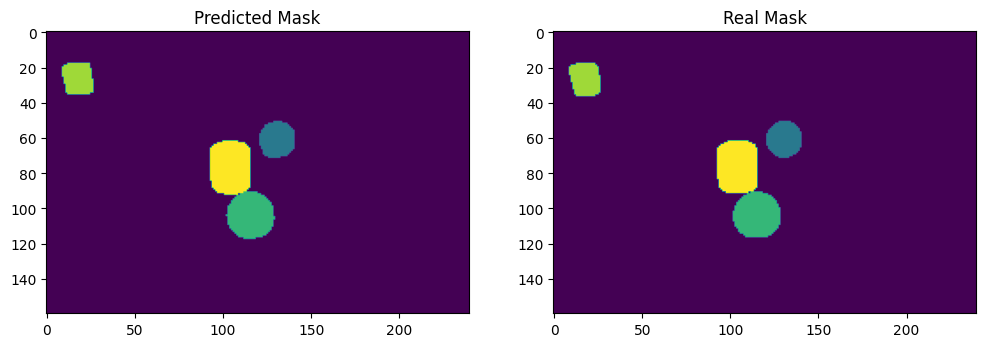

jaccard_score: 0.9343822002410889


Epoch 2/5 (Val): 100%|██████████| 500/500 [00:42<00:00, 11.64it/s, val_loss=0.0227]


torch.Size([44, 160, 240])
torch.Size([44, 160, 240])


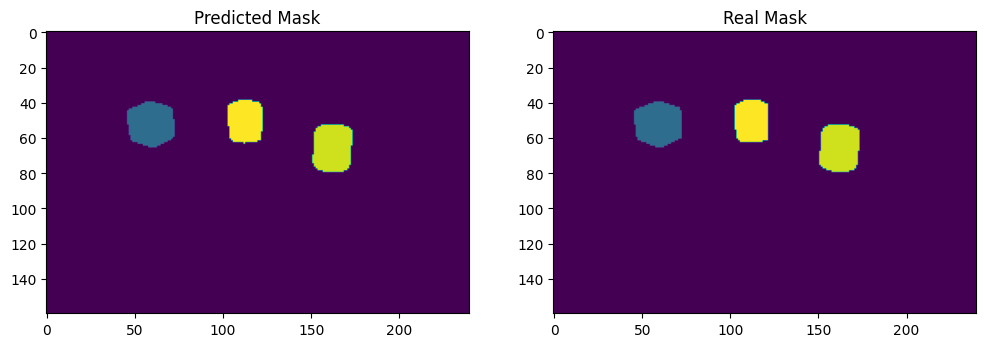

jaccard_score: 0.9352805614471436


Epoch 3/5 (Val): 100%|██████████| 500/500 [00:42<00:00, 11.63it/s, val_loss=0.0232]


torch.Size([44, 160, 240])
torch.Size([44, 160, 240])


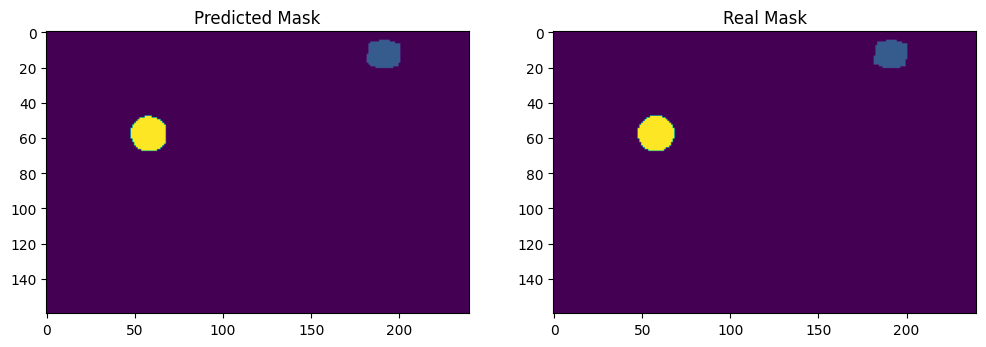

jaccard_score: 0.9355959892272949


Epoch 4/5 (Val): 100%|██████████| 500/500 [00:42<00:00, 11.64it/s, val_loss=0.0226]


torch.Size([44, 160, 240])
torch.Size([44, 160, 240])


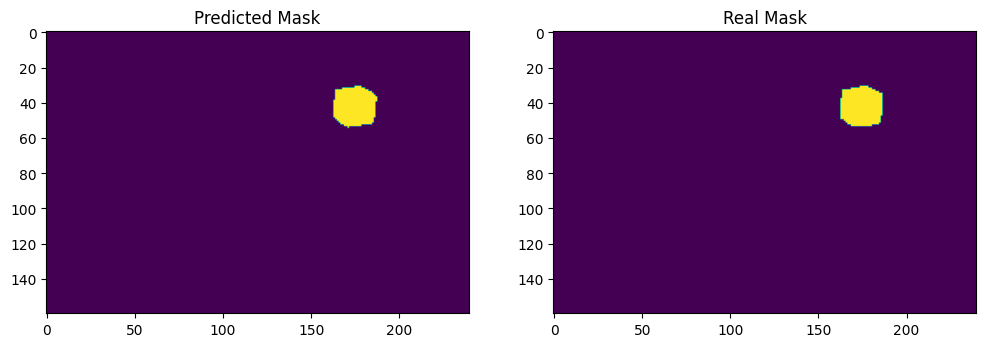

jaccard_score: 0.935500979423523


Epoch 5/5 (Val): 100%|██████████| 500/500 [00:42<00:00, 11.64it/s, val_loss=0.0226]


torch.Size([44, 160, 240])
torch.Size([44, 160, 240])


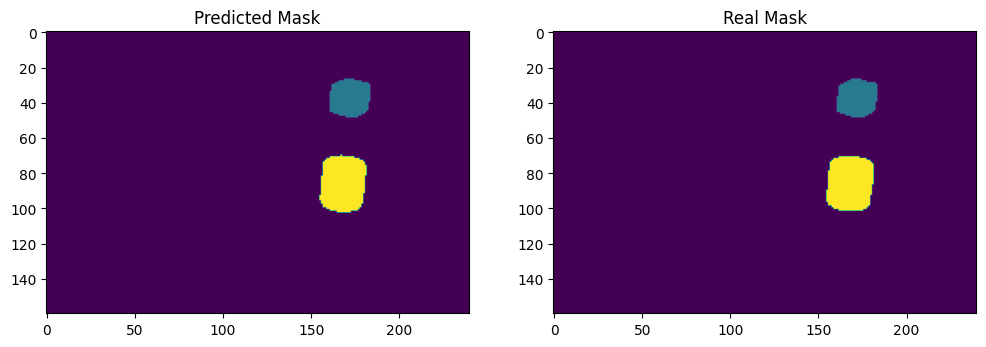

jaccard_score: 0.9359220862388611


In [25]:
from tqdm import tqdm
from einops import rearrange



Unet_masker.to(device)

def train_model(model, trainloader, valloader, optimizer, criterion, device, epochs):
  # Training loop
  for epoch in range(epochs):
      # Training
      model.train()
      train_loss = 0
      train_tqdm = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
      for frames, labels, masks in train_tqdm:
          frames, labels, masks = frames.to(device), labels.to(device), masks.to(device)

          optimizer.zero_grad()
          frames = rearrange(frames, 'b t c h w -> (b t) c h w')
          masks = rearrange(masks, 'b t h w -> (b t) h w')
          #print(frames.shape)
          outputs = model(frames)
          #print(outputs.shape)
          #print(masks.shape)
          loss = criterion(outputs, masks.long())
          loss.backward()
          optimizer.step()
          scheduler.step()

          train_loss += loss.item()
          train_tqdm.set_postfix({'train_loss': train_loss / (train_tqdm.n + 1), 'learning_rate': optimizer.param_groups[0]['lr']})

      # Validation
      model.eval()
      val_loss = 0
      val_tqdm = tqdm(valloader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)")
      with torch.no_grad():
          val_predicted = []
          val_truth = []
          for frames, labels, masks in val_tqdm:
              frames, labels, masks = frames.to(device), labels.to(device), masks.to(device)

              frames = rearrange(frames, 'b t c h w -> (b t) c h w')
              masks = rearrange(masks, 'b t h w -> (b t) h w')
              outputs = model(frames)
              loss = criterion(outputs, masks.long())

              outputs = torch.argmax(outputs, dim=1)
              val_predicted.append(outputs[[21,43]].cpu())
              val_truth.append(masks[[21,43]].cpu())

              val_loss += loss.item()
              val_tqdm.set_postfix({'val_loss': val_loss / (val_tqdm.n + 1)})

          # Convert the tensors to numpy arrays for visualization
          print(outputs.shape)
          print(masks.shape)
          outputs = outputs.cpu().numpy()
          masks = masks.cpu().numpy()
          # Choose the first sample in the batch to visualize
          sample_id = 0

          # Plot the predicted mask and real mask
          fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
          ax1.imshow(outputs[sample_id])
          ax1.set_title("Predicted Mask")
          ax2.imshow(masks[sample_id])
          ax2.set_title("Real Mask")
          plt.show()

          results_mask_tensor = torch.cat(val_predicted, dim=0)  # Concatenate tensors
          actual_mask_tensor = torch.cat(val_truth, dim=0)
          jaccard = compute_jaccard(results_mask_tensor, actual_mask_tensor)
          print(f"jaccard_score: {jaccard}")


train_model(Unet_masker, trainloader, valloader, optimizer, criterion, device, num_epochs)


In [26]:
torch.save(Unet_masker.state_dict(), "best_model_15_epochs.pkl")

In [11]:
### Load model:
unet_saved_data = torch.load("best_model_15_epochs.pkl", map_location=device)
Unet_masker.load_state_dict(unet_saved_data)
Unet_masker.to(device)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [15]:
### Generate masks for unlabeled
from tqdm import tqdm
from einops import rearrange

### Unlabeled Dataloader method
def load_unlabeled_data(root, annotation_file, batch_size=1):
    preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            # transforms.Resize(299),  # image batch, resize smaller edge to 299
            # transforms.Resize((160,240)),
            # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
            transforms.Normalize((0.61749697, 0.6050092, 0.52180636), (2.1824553, 2.1553133, 1.9115673)),
        ])

    dataset = VideoFrameDataset(
        root_path=root,
        annotationfile_path=annotation_file,
        num_segments=1,
        frames_per_segment=22,
        imagefile_template='image_{:d}.png',
        transform=preprocess,
        mask=False,
        test_mode=False
    )

    dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=1, # arbitrarily chosen
            pin_memory=True
        )
    return dataloader

unlabeledloader = load_unlabeled_data('Dataset_Student/unlabeled/data/', 'Dataset_Student/unlabeled/annotations.txt', 1)

# this maybe only works with batch size 1 (?) so test if using with more
#def generate_unlabeled_masks(model, unlabeledloader):
#  model.eval()
#  unlabeled_tqdm = tqdm(unlabeledloader, desc=f"(Generating)")
#  output_masks = []
#  for frames, labels in unlabeled_tqdm:
#      frames, labels = frames.to(device), labels.to(device)
#
#      with torch.no_grad():
#        frames = rearrange(frames, 'b t c h w -> (b t) c h w')
#        outputs = model(frames)
#        outputs = torch.argmax(outputs, dim=1)
#        outputs = outputs.unsqueeze(0)
#        output_masks.append(outputs.cpu())
#  
#  results_mask_tensor = torch.cat(output_masks, dim=0)
#  print(results_mask_tensor.shape)
#
#  return results_mask_tensor

import os
import torch

def generate_unlabeled_masks(model, unlabeledloader, save_dir='output_masks'):
    model.eval()
    unlabeled_tqdm = tqdm(unlabeledloader, desc=f"(Generating)")

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for idx, (frames, labels) in enumerate(unlabeled_tqdm):
        frames, labels = frames.to(device), labels.to(device)

        with torch.no_grad():
            frames = rearrange(frames, 'b t c h w -> (b t) c h w')
            outputs = model(frames)
            outputs = torch.argmax(outputs, dim=1)
            output_file = os.path.join(save_dir, f'mask_{idx}.pt')
            torch.save(outputs.cpu(), output_file)

generate_unlabeled_masks(Unet_masker, unlabeledloader)

#unlabeled_masks = generate_unlabeled_masks(Unet_masker, unlabeledloader)




(Generating): 100%|██████████| 13000/13000 [16:04<00:00, 13.47it/s]


In [18]:
!zip -r output_masks.zip output_masks

Streaming output truncated to the last 5000 lines.
  adding: output_masks/mask_10475.pt (deflated 100%)
  adding: output_masks/mask_5335.pt (deflated 100%)
  adding: output_masks/mask_1983.pt (deflated 100%)
  adding: output_masks/mask_5611.pt (deflated 100%)
  adding: output_masks/mask_10779.pt (deflated 100%)
  adding: output_masks/mask_12999.pt (deflated 100%)
  adding: output_masks/mask_6739.pt (deflated 100%)
  adding: output_masks/mask_1340.pt (deflated 100%)
  adding: output_masks/mask_5360.pt (deflated 100%)
  adding: output_masks/mask_3615.pt (deflated 100%)
  adding: output_masks/mask_6834.pt (deflated 100%)
  adding: output_masks/mask_2774.pt (deflated 100%)
  adding: output_masks/mask_4160.pt (deflated 100%)
  adding: output_masks/mask_4303.pt (deflated 100%)
  adding: output_masks/mask_1050.pt (deflated 100%)
  adding: output_masks/mask_9089.pt (deflated 100%)
  adding: output_masks/mask_7280.pt (deflated 100%)
  adding: output_masks/mask_3298.pt (deflated 100%)
  adding: 

In [ ]:
import os

def load_all_masks(save_dir='output_masks'):
    files = sorted(os.listdir(save_dir))
    mask_files = [f for f in files if f.startswith('mask_') and f.endswith('.pt')]
    masks = []
    for file in mask_files:
        mask_path = os.path.join(save_dir, file)
        mask = torch.load(mask_path)
        masks.append(mask)
    return torch.cat(masks, dim=0)

masks_tensor = load_all_masks()
labels_tensor = torch.zeros(masks_tensor.size(0))  # Dummy labels; replace with actual labels if needed

dataset = TensorDataset(masks_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [31]:
x = torch.rand(2, 3, 4, 5)
x.shape
x.unsqueeze(0).shape

torch.Size([1, 2, 3, 4, 5])

In [7]:
from pathlib import Path
import random
from datetime import datetime
import time

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights, VPTRFormerFAR, VPTRFormerNAR
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import KTHDataset, BAIRDataset, MovingMNISTDataset
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training, write_code_files
from utils import set_seed, PSNR, SSIM, MSEScore, get_dataloader

!pip install lpips
import lpips
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
set_seed(2021)

In [9]:
resume_ckpt = Path('epoch_22.tar') #The trained Transformer checkpoint file
#resume_ckpt = None
resume_AE_ckpt = Path('epoch_4.tar') #The trained AutoEncoder checkpoint file
num_past_frames = 11
num_future_frames = 11
encH, encW, encC = 6, 6, 528
TSLMA_flag = False
rpe = True
model_flag = 'FAR' #'NAR' for NAR model, 'FAR' for FAR model

img_channels = 3 # 1 for KTH and MovingMNIST, 3 for BAIR
N = 1
loss_name_list = ['T_MSE', 'T_GDL', 'T_gan', 'T_total', 'Dtotal', 'Dfake', 'Dreal']

In [10]:
#Set the padding_type to be "zero" for BAIR dataset
VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3).to(device)
VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Tanh').to(device)
VPTR_Enc = VPTR_Enc.eval()
VPTR_Dec = VPTR_Dec.eval()

if model_flag == 'NAR':
    VPTR_Transformer = VPTRFormerNAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                         nhead=8, num_encoder_layers=4, num_decoder_layers=8, dropout=0.1, 
                                         window_size=4, Spatial_FFN_hidden_ratio=4, TSLMA_flag = TSLMA_flag, rpe=rpe).to(device)
else:
    VPTR_Transformer = VPTRFormerFAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                    nhead=8, num_encoder_layers=6, dropout=0.1, 
                                    window_size=4, Spatial_FFN_hidden_ratio=4, rpe=rpe).to(device)

VPTR_Transformer = VPTR_Transformer.eval()

#load the trained autoencoder, we initialize the discriminator from scratch, for a balanced training
loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec}, {}, resume_AE_ckpt, loss_name_list, map_location=device)
if resume_ckpt is not None:
    loss_dict, start_epoch = resume_training({'VPTR_Transformer': VPTR_Transformer}, 
                                             {}, resume_ckpt, loss_name_list, map_location=device)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [39]:
train_loader, val_loader, test_loader, renorm_transform = get_dataloader('BAIR', N, 'Dataset_Student/train', 'Dataset_Student/val', test_past_frames = 11, 
                                                     test_future_frames = 11, ngpus = 1, num_workers = 1)

In [12]:
def plot_model_result(pred, fig_name, num_frames, n = 2):
    """
    Plot and save figure
    """
    fig, ax = plt.subplots(1, num_frames, figsize = (num_frames, 1))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    for j in range(num_frames):
        ax[j].set_axis_off()
        
        img = pred[:, j, :, :, :].clone()
        img = renorm_transform(img)
        img = torch.clamp(img, min = 0., max = 1.)
        img = img[n, ...]

        img = transforms.ToPILImage()(img)
        ax[j].imshow(img, cmap = 'gray')
    # fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')
    
def FAR_RIL_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    recurrently inference over Latent space, get a worse result
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"

    past_gt_feats = VPTR_Enc(past_frames)
    pred_feats = VPTR_Transformer(past_gt_feats)
    
    pred_frames = VPTR_Dec(pred_feats[:, -1:, ...])
    for i in range(1, num_pred):
        if i == 1:
            input_feats = torch.cat([past_gt_feats, pred_feats[:, -1:, ...]], dim = 1)
        elif i < VPTR_Transformer.num_future_frames:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
        else:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
            input_feats = input_feats[:, 1:, ...]
        
        pred_feats = VPTR_Transformer(input_feats)
        pred_future_frame = VPTR_Dec(pred_feats[:, -1:, ...])
        pred_future_feat = pred_feats[:, -1:, ...]
        pred_frames = torch.cat([pred_frames, pred_future_frame], dim = 1)
    
    return pred_frames, future_frames

def FAR_RIP_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    recurrently inference over pixel space
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"

    past_gt_feats = VPTR_Enc(past_frames)
    pred_feats = VPTR_Transformer(past_gt_feats)
    
    pred_frames = VPTR_Dec(pred_feats[:, -1:, ...])
    for i in range(1, num_pred):
        if i == 1:
            input_feats = torch.cat([past_gt_feats, pred_feats[:, -1:, ...]], dim = 1)
        elif i < VPTR_Transformer.num_future_frames:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
        else:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
            input_feats = input_feats[:, 1:, ...]
        
        pred_feats = VPTR_Transformer(input_feats)
        pred_future_frame = VPTR_Dec(pred_feats[:, -1:, ...])
        pred_future_feat = VPTR_Enc(pred_future_frame)
        pred_frames = torch.cat([pred_frames, pred_future_frame], dim = 1)
    
    return pred_frames, future_frames

def NAR_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    NAR model inference function, for the case num_pred is divisible for the num_future_frames of training. e.g. num_pred = 20, num_future_frames = 10
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"
    assert num_pred % VPTR_Transformer.num_future_frames == 0, "Mismatch of num_pred and trained Transformer"
    
    past_gt_feats = VPTR_Enc(past_frames)
    
    for i in range(0, num_pred//VPTR_Transformer.num_future_frames):
        pred_future_feats = VPTR_Transformer(past_gt_feats)
        if i == 0:
            pred_frames = VPTR_Dec(pred_future_feats)
        else:
            pred_frames = torch.cat([pred_frames, VPTR_Dec(pred_future_feats)], dim = 1)
        past_gt_feats = pred_future_feats
        
    
    return pred_frames, future_frames


def NAR_BAIR_2_to_28_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    Specifically for BAIR dataset, 2 -> 28 prediction.
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"
    #assert num_pred % VPTR_Transformer.num_future_frames == 0, "Mismatch of num_pred and trained Transformer"
    
    pred = []
    #prediction 1
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames)
    #prediction 2
    past_frames = pred_frames[:, -2:, ...]
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames)
    
    #prediction 3
    past_frames = pred_frames[:, -2:, ...]
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames[:, 0:-2, ...])
    pred_frames = torch.cat(pred, dim = 1)
    
    return pred_frames, future_frames         

In [13]:
sample = next(iter(test_loader))
num_pred = 11
with torch.no_grad():
    pred_frames, gt_frames = FAR_RIL_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device)

In [35]:
Unet_masker_untrained = UNet(                 # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    n_class=49,                      # model output channels (number of classes in your dataset)
)

In [36]:
from torch.nn.modules.loss import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch import optim


num_epochs = 5
#criterion = smp.losses.JaccardLoss(mode="multiclass")
weight = torch.ones(49)
weight[0] = 0.1
weight = weight.to(device)
steps = num_epochs * len(trainloader)
criterion = CrossEntropyLoss(weight=weight)
optimizer = optim.Adam(Unet_masker_untrained.parameters(), lr=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=steps, eta_min=0.000001)

In [11]:
def compute_jaccard(ground_truth_mask, predicted_mask):
  jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49) #.to(device)
  return jaccard(torch.Tensor(ground_truth_mask), torch.Tensor(predicted_mask))

In [50]:
data, labels, masks =next(iter(trainloader))

In [51]:
data.shape

torch.Size([2, 22, 3, 160, 240])

In [52]:
renormed = renorm_transform(data[:, 0])

In [53]:
frame = rearrange(renormed, 'f c h w -> f h w c')

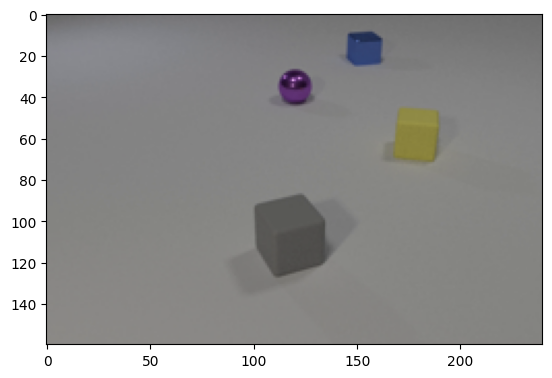

In [54]:
plt.imshow(frame[0])

In [55]:
unrenormed = data[0,0]
unrenormed = rearrange(unrenormed, 'c h w -> h w c')

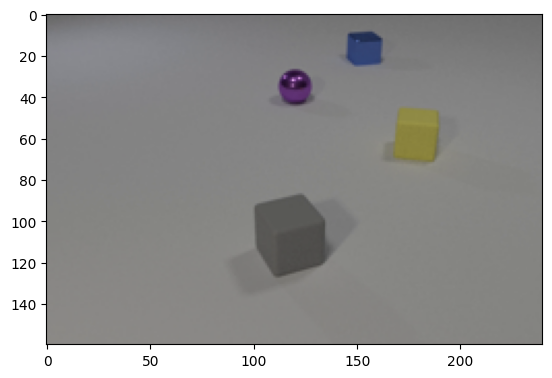

In [56]:
plt.imshow(unrenormed)

Epoch 1/5 (Val): 100%|██████████| 500/500 [01:39<00:00,  5.04it/s, val_loss=1.93]


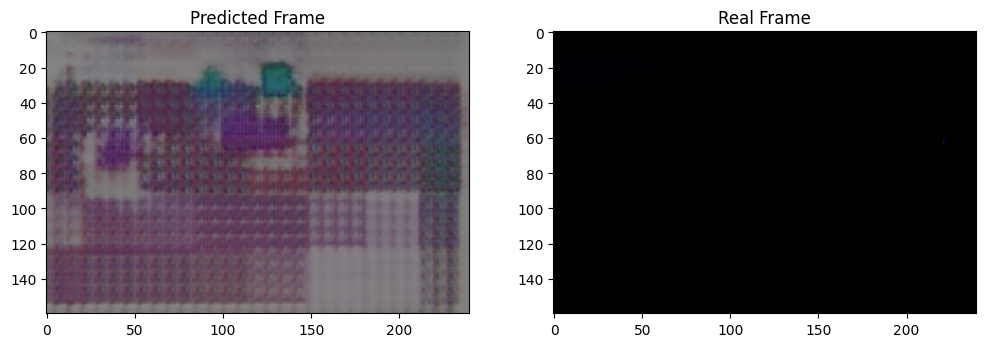

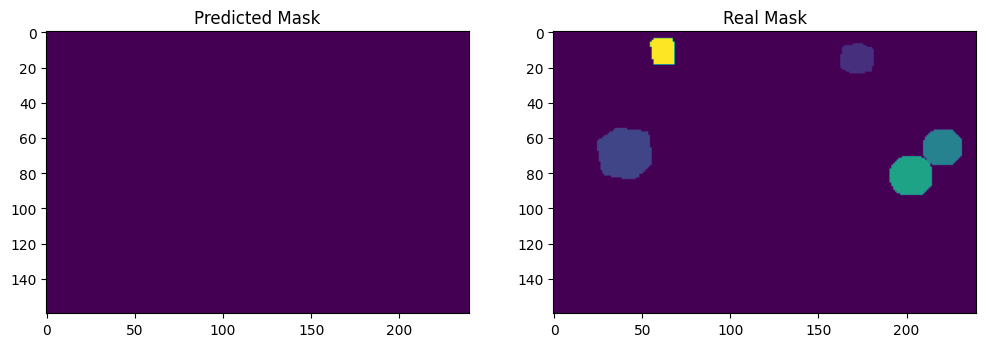

ValueError: ignored

In [58]:
from tqdm import tqdm
from einops import rearrange


def train_vptr_decoder_model(masker, encoder, decoder, transformer, trainloader, valloader, optimizer, criterion, device, epochs):
  # Training loop
  for epoch in range(epochs):
      # Training

      ## Set masker to train
      masker.train()
      encoder.eval()
      decoder.eval()
      transformer.eval()

      train_loss = 0
      train_tqdm = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")

      for frames, labels, masks in train_tqdm:
          frames, labels, masks = frames.to(device), labels.to(device), masks.to(device)

          optimizer.zero_grad()

          encoded_frames = encoder(frames[:,:11])
          predicted_frames = transformer(encoded_frames)
          decoded_predicted_frames = decoder(predicted_frames)

          decoded_predicted_frames = rearrange(decoded_predicted_frames, 'b t c h w -> (b t) c h w')
          masks = rearrange(masks[:,11:,:,:], 'b t h w -> (b t) h w')
          predicted_masks = masker(decoded_predicted_frames)
          loss = criterion(predicted_masks, masks.long())

          loss.backward()
          optimizer.step()
          scheduler.step()

          train_loss += loss.item()
          train_tqdm.set_postfix({'train_loss': train_loss / (train_tqdm.n + 1), 'learning_rate': optimizer.param_groups[0]['lr']})

      # Validation

      ## Set masker to eval
      masker.eval()

      val_loss = 0
      val_tqdm = tqdm(valloader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)")
      with torch.no_grad():
          last_frames_predicted_masks = []
          last_frames_actual_masks = []

          for frames, labels, masks in val_tqdm:
              frames, labels, masks = frames.to(device), labels.to(device), masks.to(device)

              encoded_frames = encoder(frames[:,:11])
              predicted_frames = transformer(encoded_frames)
              decoded_predicted_frames = decoder(predicted_frames)

              last_frames_actual_masks.append(masks[:,10].cpu())
              decoded_predicted_frames = rearrange(decoded_predicted_frames, 'b t c h w -> (b t) c h w')
              masks = rearrange(masks[:,11:,:,:], 'b t h w -> (b t) h w')
              predicted_masks = masker(decoded_predicted_frames)

              last_frames_predicted_masks.append(predicted_masks[[10,21]].cpu())

              loss = criterion(predicted_masks, masks.long())

              val_loss += loss.item()
              val_tqdm.set_postfix({'val_loss': val_loss / (val_tqdm.n + 1)})

          # Convert the tensors to numpy arrays for visualization
          outputs = torch.argmax(predicted_masks, dim=1)
          outputs = outputs.cpu().numpy()
          masks = masks.cpu().numpy()
          frames = frames.cpu().numpy()
          decoded_predicted_frames.cpu().numpy()
          # Choose the first sample in the batch to visualize
          sample_id = 10

          # Plot the predicted frame and real frame
          fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
          pred_frame = renorm_transform(decoded_predicted_frames)
          pred_frame = torch.clamp(pred_frame[sample_id], min=0., max=1.)
          ax1.imshow(rearrange(pred_frame, 'c h w -> h w c').cpu())
          ax1.set_title("Predicted Frame")
          
          ax2.imshow(rearrange(frames[0, sample_id+11], 'c h w -> h w c'))
          ax2.set_title("Real Frame")
          plt.show()

          # Plot the predicted mask and real mask
          fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
          ax1.imshow(outputs[sample_id])
          ax1.set_title("Predicted Mask")
          ax2.imshow(masks[sample_id])
          ax2.set_title("Real Mask")
          plt.show()

          results_mask_tensor = torch.cat(last_frames_predicted_masks, dim=0)  # Concatenate tensors
          actual_mask_tensor = torch.cat(last_frames_actual_masks, dim=0)
          print(results_mask_tensor.shape)
          print(actual_mask_tensor.shape)
          compute_jaccard(actual_mask_tensor, results_mask_tensor)


Unet_masker_untrained.to(device)
train_vptr_decoder_model(Unet_masker_untrained, VPTR_Enc, VPTR_Dec, VPTR_Transformer, trainloader, valloader, optimizer, criterion, device, num_epochs)
